# Convolution package 

In [1]:
import sys,os
#sys.path.append(os.path.abspath('/'))
os.environ["XLA_FLAGS"]="--xla_cpu_enable_xprof_traceme"
os.environ["JAX_ENABLE_X64"]="True"
import numpy as np 
import jax.numpy as jnp 
import jax
from jax.experimental import sparse as jaxsparse
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel
from astropy.convolution import convolve_fft as astropy_convolvefft
from astropy.convolution import convolve as astropy_convolve
from ipywidgets import widgets,interact
from tqdm.notebook import tqdm

#the package:
import jax_convolution as jc

NB: The shape of the kernel must be odd. If not, it needs to be resampled to be odd.


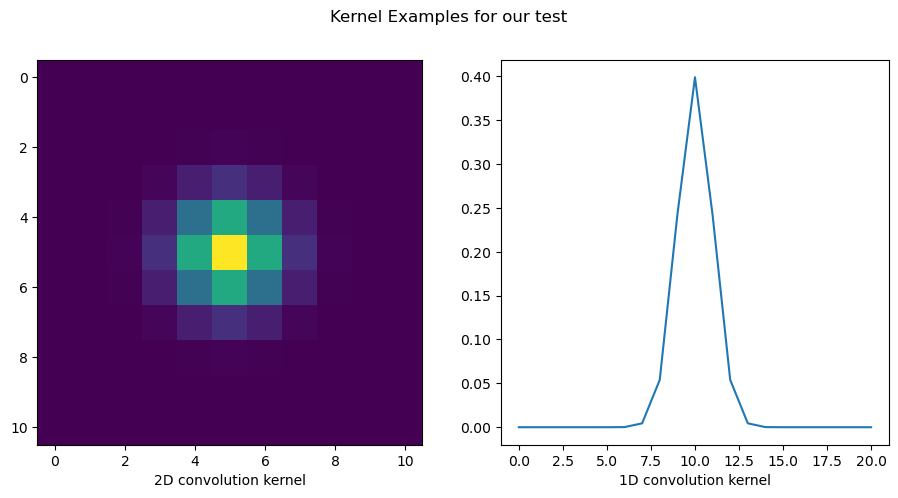

In [2]:
#creating the test data

kernel2D=Gaussian2DKernel(1,x_size=11,y_size=11).array
kernel1D=Gaussian1DKernel(1,x_size=21).array
fig,ax=plt.subplots(1,2,figsize=(11,5))
ax[0].imshow(kernel2D)
ax[0].set_xlabel("2D convolution kernel")
ax[1].plot(kernel1D)
ax[1].set_xlabel("1D convolution kernel")
fig.suptitle("Kernel Examples for our test") 
print("NB: The shape of the kernel must be odd. If not, it needs to be resampled to be odd.")

In [3]:
L,M,N=100,15,15
DATA_1D=jnp.asarray(np.random.normal(size=L))
DATA_2D=jnp.asarray(np.random.normal(size=(M,N)))
DATA_3D=jnp.asarray(np.random.normal(size=(L,M,N)))

## Fourier

### Mini-tutorial

* **A simple convolution (useful for when it's done only one time)**

In [4]:
Conv1D=jc.convolve_fft(DATA_1D,kernel1D) #convolving a 1D vector with a 1D kernel
Conv2D=jc.convolve_fft(DATA_2D,kernel2D) #convolving a 2D image with a 2D kernel
Conv3D_1D=jc.convolve_fft(DATA_3D,kernel1D) #convolving a 3D cube with a 1D kernel
Conv3D_2D=jc.convolve_fft(DATA_3D,kernel2D) #convolving a 3D cube with a 2D kernel

* **Saving the convolution kernel's Fourier transform, then convolving (faster when a convolution is repeated over many iterations, with the same kernel.)**

In [5]:
### For 1D convolution of 1D data ### 
#First, calculate the padded, shifted, FF-transformed kernels. 
#This step only needs to be done once. 
FFT_kernel1D=jc.pad_fft_kernel(kernel1D,DATA_1D.shape)
#Then, plug in convolution function: 
Conv2D=jc.convolve_from_ker1D_fft(DATA_1D,FFT_kernel1D,DATA_1D.shape,kernel1D.shape)
#NB: the "ker_shape" argument has to be the *unpadded* kernel shape. 

In [6]:
### For 2D convolution of 2D data ### 
#First, calculate the padded, shifted, FF-transformed kernels. 
#This step only needs to be done once. 
FFT_kernel2D=jc.pad_fft_kernel(kernel2D,DATA_2D.shape)
#Then, plug in convolution function: 
Conv2D=jc.convolve_from_ker2D_fft(DATA_2D,FFT_kernel2D,DATA_2D.shape,kernel2D.shape)
#NB: the "ker_shape" argument has to be the *unpadded* kernel shape. 

In [7]:
### For 2D and 1D convolution of 3D data ### 
#First, calculate the padded, shifted, FF-transformed kernels. 
#This step only needs to be done once. 
FFT_kernel1D,FFT_kernel2D=jc.pad_fft_kernel((kernel1D,kernel2D),DATA_3D.shape)
#Then, plug in convolution function: 
Conv3D_1D=jc.convolve_from_ker1D_fft(DATA_3D,FFT_kernel1D,DATA_3D.shape,kernel1D.shape)
Conv3D_2D=jc.convolve_from_ker2D_fft(DATA_3D,FFT_kernel2D,DATA_3D.shape,kernel2D.shape)
#NB: the "ker_shape" argument has to be the *unpadded* kernel shape. 

## Matrix 

### Mini-tutorial: Stationary Convolution

In [8]:
### For 1D convolution of 1D data ### 
#First, calculate the convolution matrix. 
#This step only needs to be done once. 
MAT_1D=jc.generate_1D_conv_matrix(kernel1D,DATA_1D.shape)
#Then, plug in convolution function: 
Conv_res_mat1D_1D=jc.conv_1D_Mat(DATA_1D,MAT_1D,DATA_1D.shape,kernel1D.shape)

In [9]:
### For 1D convolution of 3D data ### 
#First, calculate the convolution matrix. 
#This step only needs to be done once. 
MAT_1D=jc.generate_1D_conv_matrix(kernel1D,DATA_3D.shape)
#Then, plug in convolution function: 
Conv_res_mat1D_1D=jc.conv_1D_Mat(DATA_3D,MAT_1D,DATA_3D.shape,kernel1D.shape)

In [10]:
### For 2D convolution of 2D data ### 
#First, calculate the convolution matrix. 
#This step only needs to be done once. 
MAT_2D=jc.generate_2D_conv_matrix(kernel2D,DATA_2D.shape)
#Then, plug in convolution function: 
Conv_res_mat2D_2D=jc.conv_2D_Mat(DATA_2D,MAT_2D,DATA_2D.shape,kernel2D.shape)

In [11]:
### For 2D convolution of 3D data ### 
#First, calculate the convolution matrix. 
#This step only needs to be done once. 
MAT_2D=jc.generate_2D_conv_matrix(kernel2D,DATA_3D.shape)
#Then, plug in convolution function: 
Conv_res_mat2D_3D=jc.conv_2D_Mat(DATA_3D,MAT_2D,DATA_3D.shape,kernel2D.shape)

### Mini-tutorial: Non-Stationary Convolution

  0%|          | 0/15 [00:00<?, ?it/s]

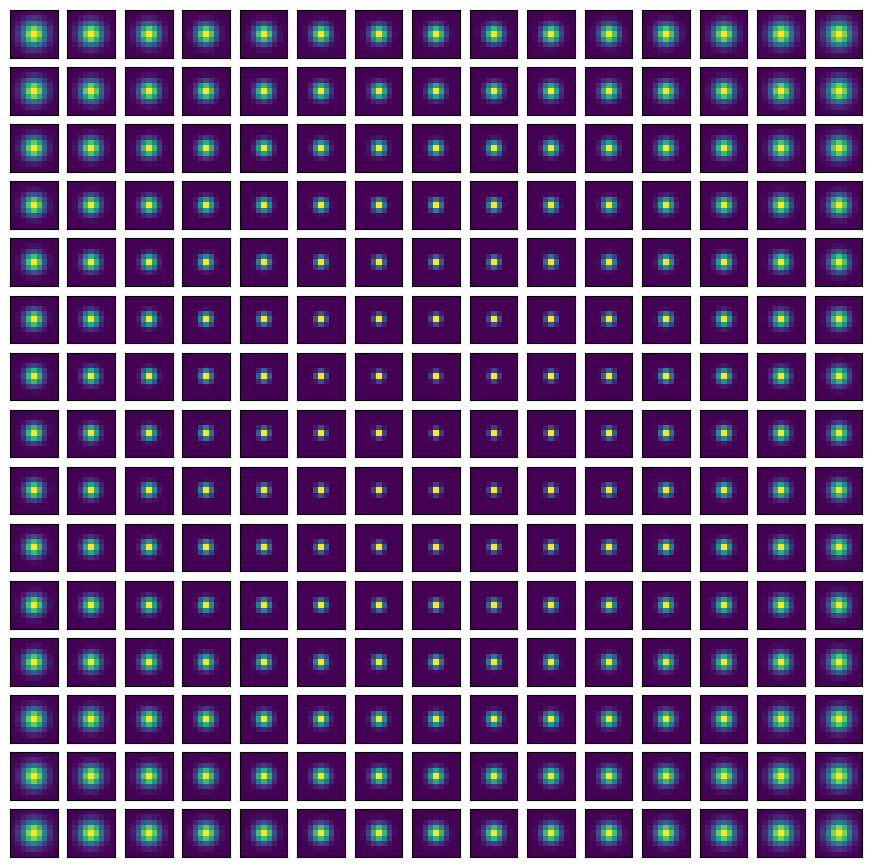

In [12]:
PSF_size=Gaussian2DKernel(10,x_size=M,y_size=N).array
max_PSF=(PSF_size.max())*1.2
PSF_size=500*(max_PSF-PSF_size)
ker_m,ker_n=9,9
PSF_list_numpy=np.zeros((ker_m,ker_n,M,N),dtype=np.float64)
fig,ax=plt.subplots(M,N,figsize=(11,11))
Sum=[]
for i in tqdm(range(M)):
    for j in range(N):
        PSF_list_numpy[:,:,i,j]=Gaussian2DKernel(PSF_size[i,j],x_size=ker_m,y_size=ker_n).array
        ax[i,j].imshow(PSF_list_numpy[:,:,i,j])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
plt.show()

In [13]:
MAT_2D_nonstat=jc.generate_2D_conv_matrix(PSF_list_numpy,DATA_2D.shape)

In [14]:
Conv_res_mat2D_2D_nonstat=jc.conv_2D_Mat(DATA_2D,MAT_2D_nonstat,DATA_2D.shape,PSF_list_numpy[:,:,0,0].shape)

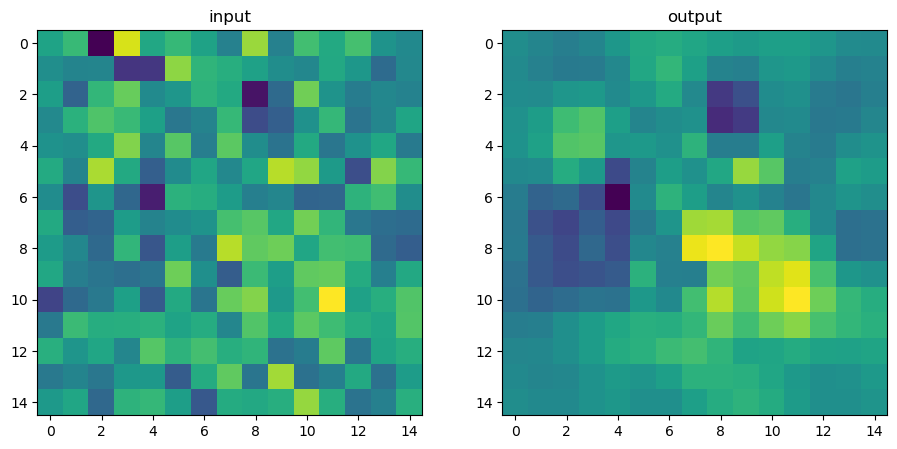

In [15]:
fig,ax=plt.subplots(1,2,figsize=(11,5))
ax[0].imshow(DATA_2D)
ax[0].set_title("input")
ax[1].set_title("output")
ax[1].imshow(Conv_res_mat2D_2D_nonstat)
plt.show()

# Convolution for a 3D data set

In [16]:
MAT_2D=jc.generate_2D_conv_matrix(kernel2D,DATA_2D.shape)#,sparse=True)
Conv_res_mat2D_2D=jc.conv_2D_Mat(DATA_2D,MAT_2D,DATA_2D.shape,kernel2D.shape)

In [17]:
MAT_1D=jc.generate_1D_conv_matrix(kernel1D,DATA_1D.shape)#,sparse=True)
Conv_res_mat1D_1D=jc.conv_1D_Mat(DATA_1D,MAT_1D,DATA_1D.shape,kernel1D.shape)

In [18]:
MAT_2D=jc.generate_2D_conv_matrix(kernel2D,DATA_3D.shape)#,sparse=True)
Conv_res_mat2D_3D=jc.conv_2D_Mat(DATA_3D,MAT_2D,DATA_3D.shape,kernel2D.shape)

In [19]:
MAT_1D=jc.generate_1D_conv_matrix(kernel1D,DATA_3D.shape)#,sparse=True)
Conv_res_mat1D_3D=jc.conv_1D_Mat(DATA_3D,MAT_1D,DATA_3D.shape,kernel1D.shape)